<a href="https://colab.research.google.com/github/francescoS01/blob_detection/blob/main/blob_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###  **ASSIGNMENT 7: Blob Detector with LoG Filter**
#### Francesco Simonetti


In [157]:
!git clone https://github.com/francescoS01/blob_detection.git

fatal: destination path 'blob_detection' already exists and is not an empty directory.


In [158]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage as ndimage
from matplotlib.patches import Circle
import heapq


### **1. Utils**

##### **1.1 blob_detection_plot**:
This function creates a plot of the original image with detected blobs surrounded by circles. It takes an image and a list of detected blob points as input, where each point is represented as a tuple containing the (x, y) coordinates, associated value, and sigma value used for detection. The function plots the image, adds circles around the


In [159]:
def blob_detection_plot(image, points):
    """
    Creates a plot of the original image with detected blobs surrounded by circles.

    Args:
        image (ndarray): The image on which blobs were detected.
        points (list): list of points detected during blob detection.
                       each point is represented as a tuple (x, y, value, sigma),where: 
                        - x and y: the coordinates of the point (pixel),
                        - value: associated value (value of pixel) in the coordinate x,y
                        - sigma: is the sigma value used for detection.

    Returns:
        None: The image with detected blobs surrounded by circles is displayed.
    """

    image_copiata = np.copy(image)
    fig, ax = plt.subplots()
    ax.imshow(image_copiata, cmap='gray')
    ax.axis('off')

    for point in points:
        x, y, _, sigma = point
        # draw a circle with radius sigma on the original image 
        circle = Circle((y, x), radius=sigma, color='red', fill=False)
        ax.add_patch(circle)
    
    plt.show()
    plt.close()


##### **1.2 find_maxima**: 
This function calculates the maxima (the largest values) of the matrix. It allows the user to specify the maximum number of maxima to find. For each maximum, it creates a quadruple containing the coordinates of the point, its value, and the associated sigma. Finally, it returns all these quadruples within an array.


In [160]:
def find_maxima(matrix, num_max, sigma):
    """
    Finds n maxima in the provided matrix.

    Args:
        matrix (numpy.ndarray): The filtered matrix in which to find the maxima.
        num_max (int): The number of maxima to find.
        sigma: The sigma value used to calculate the filtered matrix.

    Returns:
        list: A list of tuples containing the maxima, represented as x, y (cooridnate of the point), 
              value (value in the matritrix at point x,y) and sigma.

    """
    
    heap = []

    for x in range(matrix.shape[0]):
        for y in range(matrix.shape[1]):
            valore = matrix[x, y]
            
            if len(heap) < num_max:
                heapq.heappush(heap, (abs(valore), x, y, valore, sigma))
            else:
                heapq.heappushpop(heap, (abs(valore), x, y, valore, sigma))

    punti_massimi = [(x, y, valore, sigma) for (_, x, y, valore, sigma) in heap]

    return punti_massimi

##### **1.3. filter_max_points** = iejvi

In [161]:
def filter_max_points(punti_massimi):
    punti_filtrati = []

    for punto in punti_massimi:
        x1, y1, value1, sigma1 = punto
        trovato = False

        for i, altro_punto in enumerate(punti_filtrati):
            x2, y2, value2, sigma2 = altro_punto
            points_distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            min_dist = min(sigma1,sigma2)

            if points_distance < 2*min_dist:
                trovato = True
                # Se il valore del punto corrente è maggiore, sostituisci il punto precedente
                if value1 > value2:
                    punti_filtrati[i] = punto
                break

        # Se non è stato trovato un punto vicino con un valore minore, aggiungi il punto corrente
        if not trovato:
            punti_filtrati.append(punto)
            

    return punti_filtrati

### **2. Filter and convolution**
**2.1 gassian_function** = ihgqhewr
**2.2 filter_create** = ihgqhewr


In [162]:
def gaussian_function(x,y,sigma):
    kernel_value = -1 / (np.pi * sigma ** 2) * (1 - (x ** 2 + y ** 2) / (2 * sigma ** 2)) * np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    return kernel_value


def filter_create(sigma):
    x = int(np.ceil(sigma * 6))
    # Creazione della griglia di coordinate centrata
    x_values = np.arange(-(x // 2), x // 2 +1)
    y_values = np.arange(-(x // 2), x // 2 +1)
    x, y = np.meshgrid(x_values, y_values)
    filter_size = len(x_values)

    # Calcolo dei valori dei pixel
    filter = gaussian_function(x, y, sigma)

    return filter, filter_size

**2.3 filter_convolution** = ihgqhewr

In [163]:
# convolution of filter in the image
def filter_convolution(image, filter, filter_size):

    # image dim
    image_row, image_col = image.shape[:2]

    # filter dim
    filter_col = filter_size
    filter_row = filter_size

    # filter_matrix (inizalize to 0)
    filter_matrix_row = (image_row - filter_row) +1
    filter_matrix_col = (image_col - filter_col) +1
    filter_matrix = np.zeros((filter_matrix_row, filter_matrix_col))

    for x in range(filter_matrix_row):
        for y in range(filter_matrix_col):
            filter_matrix[x, y] = np.sum(image[x:x + filter_size, y:y + filter_size] * filter)

    return filter_matrix

### **3. Complete Program Execution**

prova

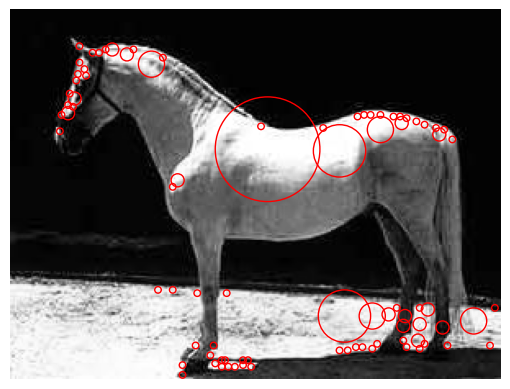

In [164]:
def blob_detection(sigmas, image_path, num_max):
    """
    executes blob detection on an image using the Laplacian of Gaussian (LoG) method.

    INPUT:
    sigmas (list): List of sigma values to use for creating LoG filters.
    image_path (str): Path of the image on which to perform blob detection.
    num_max (int): Maximum number of points of interest to be detected for each sigma scale.

    OUTPUT:
    No directly returned value. The function creates a plot of the input image with detected blobs surrounded by circles.
    """

    #image
    im = Image.open(image_path) # open the image
    image = np.array(im)
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # array taht contain the points of interest
    max_points = []

    for sigma in sigmas:

        # create the filter and take its dimention
        filter, filter_size = filter_create(sigma)
        # plot(filter_size, filter, "my_filter")

        # do the padding to maintain the coordinates
        image_padding = np.pad(gray_image, int((filter_size-1)/2), mode='edge')

        # convolution of filter on the image
        filter_image = filter_convolution(image_padding, filter, filter_size)

        # take num_max max of the filter image with fixed sigma
        max_points += find_maxima(filter_image, num_max, sigma)


    # points that are very close to each other with respect to sigma are eliminated
    max_points = filter_max_points(max_points.copy())

    # the points of interest are circled and the plot is made
    blob_detection_plot(gray_image, max_points)



"""
sigmas = [1, 2, 4, 8, 16, 32]
image_path = "horse160.png"
num_max = 100 # number of maximum points that will be taken for every sigma

blob_detection(sigmas, image_path, num_max)

"""
sigmas = [2, 4, 8, 16, 32]
num_max = 400

# image 1
image_path = "blob_detection/image/horse024.png"
blob_detection(sigmas, image_path, num_max)

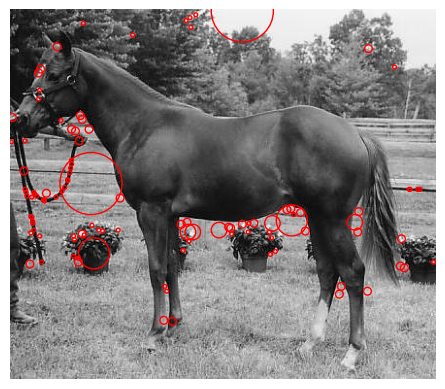

In [165]:
image_path = "blob_detection/image/horse043.png"
#image_name = "horse043.png"
blob_detection(sigmas, image_path, num_max)

prova